In [ ]:
import json

# ===============================
# 1. Load the JSON Data
# ===============================
with open("./emg_data2.json", "r") as file:
    data = json.load(file)

# Filter out EMG data where formattedTime is before "00:00" and after "00:05:16.671"
emg_data = [entry for entry in data["emgData"] if "00:00" <= entry["formattedTime"] <= "00:05:16.670"]
word_events = data["wordEvents"]  # Keep word events as they are

# (Optional) Ensure the word events are sorted by timestamp.
word_events = sorted(word_events, key=lambda event: event["timestamp"])

# ===============================
# 2. Create Labeled Windows with Sliding Window Labeling
# ===============================
window_size = 25  # Number of EMG samples per window.
stride = 12       # Number of samples to shift the window each time.

def create_labeled_windows(emg_data, word_events, target_word):
    labeled_windows = []  # This will store each window along with its binary label.

    for start in range(0, len(emg_data) - window_size + 1, stride):
        # Extract the current window of EMG samples.
        window = emg_data[start : start + window_size]

        # Determine the time span of this window.
        window_start_time = window[0]["timestamp"]
        window_end_time = window[-1]["timestamp"]

        # Find any word events that occur within the window.
        events_in_window = [
            event for event in word_events
            if window_start_time <= event["timestamp"] <= window_end_time
        ]

        # Assign binary labels: 1 if target word appears, else 0.
        label = 1 if any(event["word"] == target_word for event in events_in_window) else 0

        labeled_windows.append({
            "emg_data": [sample["value"] for sample in window],  # Extract only EMG values
            "start_timestamp": window[0]["timestamp"],
            "end_timestamp": window[-1]["timestamp"],
            "label": label
        })

    return labeled_windows

# ===============================
# 3. Generate and Save Labeled JSON
# ===============================
target_word = "Banheiro"  # Change this to the word you are interested in.
labeled_data = create_labeled_windows(emg_data, word_events, target_word)

# Save labeled data to a JSON file.
with open("labeled_data.json", "w") as outfile:
    json.dump(labeled_data, outfile, indent=4)

print("Labeled JSON with binary labels created and saved to labeled_data.json")

Labeled JSON with binary labels created and saved to labeled_data.json


In [ ]:
len(emg_data)

6304

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

# ===============================
# 1. Load Labeled JSON Data
# ===============================
with open("./labeled_data.json", "r") as infile:
    labeled_data = json.load(infile)

# ===============================
# 2. Extract Features and Labels
# ===============================
X = []
y = []

for entry in labeled_data:
    X.append(entry["emg_data"])  # Features: list of EMG values
    y.append(entry["label"])     # Label: 1 for target word, 0 otherwise

X = np.array(X)
y = np.array(y)

# ===============================
# 3. Balance the Dataset (Undersampling Majority Class)
# ===============================
# Count occurrences of each label
label_counts = Counter(y)
min_class = min(label_counts, key=label_counts.get)  # Find the minority class (1 in this case)
max_class = max(label_counts, key=label_counts.get)  # Find the majority class (0 in this case)

# Get indices of both classes
min_indices = np.where(y == min_class)[0]
max_indices = np.where(y == max_class)[0]

# Undersample the majority class to match the minority class
np.random.seed(123)
max_indices_sampled = np.random.choice(max_indices, size=len(min_indices), replace=False)

# Combine balanced indices
balanced_indices = np.concatenate((min_indices, max_indices_sampled))
np.random.shuffle(balanced_indices)

# Apply balancing
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

print(f"Balanced dataset: {Counter(y_balanced)}")  # Should be roughly equal for both labels

# ===============================
# 4. Split Data into Training and Test Sets
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=456)

# ===============================
# 5. Preprocess: Scale the Features
# ===============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================
# 6. Train the SVM Classifier
# ===============================
svm_clf = SVC(kernel="linear", C=1.0, random_state=42)
svm_clf.fit(X_train_scaled, y_train)

# ===============================
# 7. Evaluate the Model
# ===============================
y_pred = svm_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)


Balanced dataset: Counter({0: 104, 1: 104})
Test Accuracy: 98.41%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.97      1.00      0.98        28

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.98      0.98      0.98        63



In [ ]:
from sklearn.linear_model import LogisticRegression

baseline_clf = LogisticRegression()
baseline_clf.fit(X_train, y_train)
print("Baseline Accuracy:", baseline_clf.score(X_test, y_test))


Baseline Accuracy: 0.9365079365079365


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Count occurrences of each label
num_ones = np.sum(y == 1)
num_zeros = np.sum(y == 0)

print(f"Number of 1s: {num_ones}")
print(f"Number of 0s: {num_zeros}")


Number of 1s: 104
Number of 0s: 420


In [ ]:
# Check for overlap between training and test data
overlap = np.sum([np.any(np.all(X_test_scaled[i] == X_train_scaled, axis=1)) for i in range(len(X_test_scaled))])
print(f"Number of test samples that also appear in training set: {overlap}")

from collections import Counter

print(f"Train label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")


Number of test samples that also appear in training set: 5
Train label distribution: Counter({1: 83, 0: 83})
Test label distribution: Counter({0: 21, 1: 21})


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)
dummy_pred = dummy_clf.predict(X_test_scaled)

print("Baseline Accuracy (Majority Class Prediction):", accuracy_score(y_test, dummy_pred))


Baseline Accuracy (Majority Class Prediction): 0.5


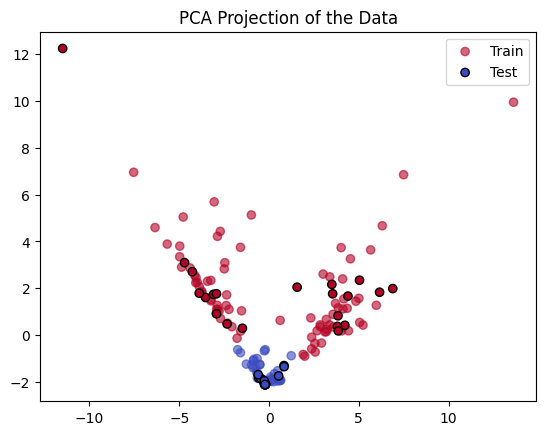

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.6, label="Train")
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', label="Test")
plt.legend()
plt.title("PCA Projection of the Data")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[21  0]
 [ 0 21]]


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svm_clf, X_train_scaled, y_train, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())


Cross-Validation Accuracy: 1.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert train and test data into arrays for similarity checking
X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)

# Compute cosine similarity between test and train samples
similarity_matrix = cosine_similarity(X_test_arr, X_train_arr)

# Check for high similarity
high_similarity = np.any(similarity_matrix > 0.99)  # Adjust threshold as needed
print("Possible data leakage:", high_similarity)


Possible data leakage: True


In [ ]:
import numpy as np

def predict_emg_window(new_emg_window, scaler, svm_clf):
    """
    Given a new EMG window (list of values), the trained scaler, and the trained SVM classifier,
    this function preprocesses the input and returns the predicted label.

    Parameters:
        new_emg_window (list or np.array): The raw EMG values for one window (length should equal window_size).
        scaler (StandardScaler): The scaler used to scale training data.
        svm_clf (SVC): The trained SVM classifier.

    Returns:
        int: The predicted label (1 if target word highlighted, 0 otherwise).
    """
    # Convert the window to a numpy array and ensure it has the shape (1, window_length)
    new_emg_window = np.array(new_emg_window).reshape(1, -1)

    # Scale the new data using the previously fitted scaler
    new_emg_window_scaled = scaler.transform(new_emg_window)

    # Predict using the trained SVM classifier
    prediction = svm_clf.predict(new_emg_window_scaled)
    return prediction[0]

# -------------------------------
# Example usage:
# -------------------------------
# Let's assume that your window size is 50 and you have a new EMG window (replace the dummy values below with your actual data)
new_emg_window = [
    1.2, 2.3, 1.1, 1.5, 1.6, 2.1, 1.0, 1.2, 1.3, 1.4,
    1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 1.8, 1.7, 1.6, 1.5,
    1.4, 1.3, 1.2, 1.1, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5,
    1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5,
    2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5
]

# Predict the label for the new window.
# Make sure 'scaler' and 'svm_clf' are defined from your training phase.
predicted_label = predict_emg_window(new_emg_window, scaler, svm_clf)
print("Predicted Label:", predicted_label)

Predicted Label: 1
